# Titanic: Machine Learning From Disaster

#### UPDATE: This second entry received a score of 0.7752 which falls below my previous score of 0.80861.

In this project, I once again try to predict who survived the Titanic shipwreck using passenger data such as Passenger class, Sex, Age, Number of Siblings and Spouses of an individual who were onboard, Number of Parents and Children of an individual who were onboard.

In this example, however, I do more exploratory analysis and build new features to try to improve from my previous submission.

I begin with the administrative tasks of importing necessary modules and importing the data.

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, cross_validation, neighbors, metrics, linear_model, ensemble, grid_search, cluster
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as s
import re
import warnings
warnings.filterwarnings("ignore")

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 1000)
sns.set_style('whitegrid')
sns.color_palette('pastel')
%matplotlib inline

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(train.head())
#print(test.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


Next, I find the mean of the passengers' ages and fill unknown values with the mean. I also create a new binary variable 'Child' and if the passenger is under 18 years of age, this variable is a 1, otherwise it is 0.

In [2]:
m = train.describe().transpose()['mean']

train.Age = train.Age.fillna(value=m.Age) # Fill null age values with the mean
train['Child'] = np.where(train['Age'] < 18, 1, 0) # Create new Child variable for individuals under 18

print(train.head())

mtest = test.describe().transpose()['mean']
test.Age = test.Age.fillna(value=mtest.Age)
test['Child'] = np.where(test['Age'] < 18, 1, 0)

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  Child  
0      0         A/5 21171   7.2500   NaN        S      0  
1      0          PC 17599  71.2833   C85        C      0  
2      0  STON/O2. 3101282   7.9250   NaN        S      0  
3      0            113803  53.1000  C123        S      0  
4      0            

Below, I create a 'Title' variable and group similar titles together. I also create a 'FamilySize' variable to indicate the size of each family onboard (including the passenger in question).

I also create a 'Surname' variable and a 'FamilyID' variable to differentiate between families with the same surname.

In [3]:
#Feature Engineering Training

title = []
for i in range(len(train.Name)):
    title.append(re.split(', |\. ',train.Name[i])[1]) # Use regular expression for isolate titles

# print(title)

train['Title'] = title # Create title variable
train.Title.value_counts()

# Combine similar titles
for i in range(len(train.Title)):
    if train.Title[i] == 'Mme':
        train.Title[i] = 'Mlle'
    elif train.Title[i] in ('Capt','Don','Major'):
        train.Title[i] = 'Sir'
    elif train.Title[i] in ('Dona','the Countess','Jonkheer'):
        train.Title[i] = 'Lady'
train.Title.value_counts()

train['FamilySize'] = train.SibSp + train.Parch + 1
# print(train.FamilySize)

surname = []
for i in range(len(train.Name)):
    surname.append(re.split(', |\. ',train.Name[i])[0])

#print(surname)
train['Surname'] = surname
train.Surname

familyid = []
for i in range(len(train)):
    familyid.append(str(train.FamilySize[i])+train.Surname[i])

train['FamilyID'] = familyid

In [4]:
#Feature Engineering Test

testtitle = []
for i in range(len(test)):
    testtitle.append(re.split(', |\. ',test.Name[i])[1])

test['Title'] = testtitle
test.Title.value_counts()

for i in range(len(test.Title)):
    if test.Title[i] == 'Mme':
        test.Title[i] = 'Mlle'
    elif test.Title[i] in ('Capt','Don','Major'):
        test.Title[i] = 'Sir'
    elif test.Title[i] in ('Dona','the Countess','Jonkheer'):
        test.Title[i] = 'Lady'

test['FamilySize'] = test.SibSp + test.Parch + 1

testsurname = []
for i in range(len(test)):
    testsurname.append(re.split(', |\. ',test.Name[i])[0])

test['Surname'] = testsurname

testfamilyid = []
for i in range(len(test)):
    testfamilyid.append(str(test.FamilySize[i])+test.Surname[i])

test['FamilyID'] = testfamilyid

Next, I encode object-type labels as numbers.

In [5]:
for i in range(len(train)):
    if pd.isnull(train.Embarked[i]):
        train.Embarked[i] = 'U' # Port of Embarkation Unknown

train.Sex = preprocessing.LabelEncoder().fit_transform(train.Sex) #Encode training data
train.Title = preprocessing.LabelEncoder().fit_transform(train.Title)
train.Embarked = preprocessing.LabelEncoder().fit_transform(train.Embarked)

test.Sex = preprocessing.LabelEncoder().fit_transform(test.Sex)
test.Title = preprocessing.LabelEncoder().fit_transform(test.Title)
test.Embarked = preprocessing.LabelEncoder().fit_transform(test.Embarked)

print(train.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Child', 'Title',
       'FamilySize', 'Surname', 'FamilyID'],
      dtype='object')


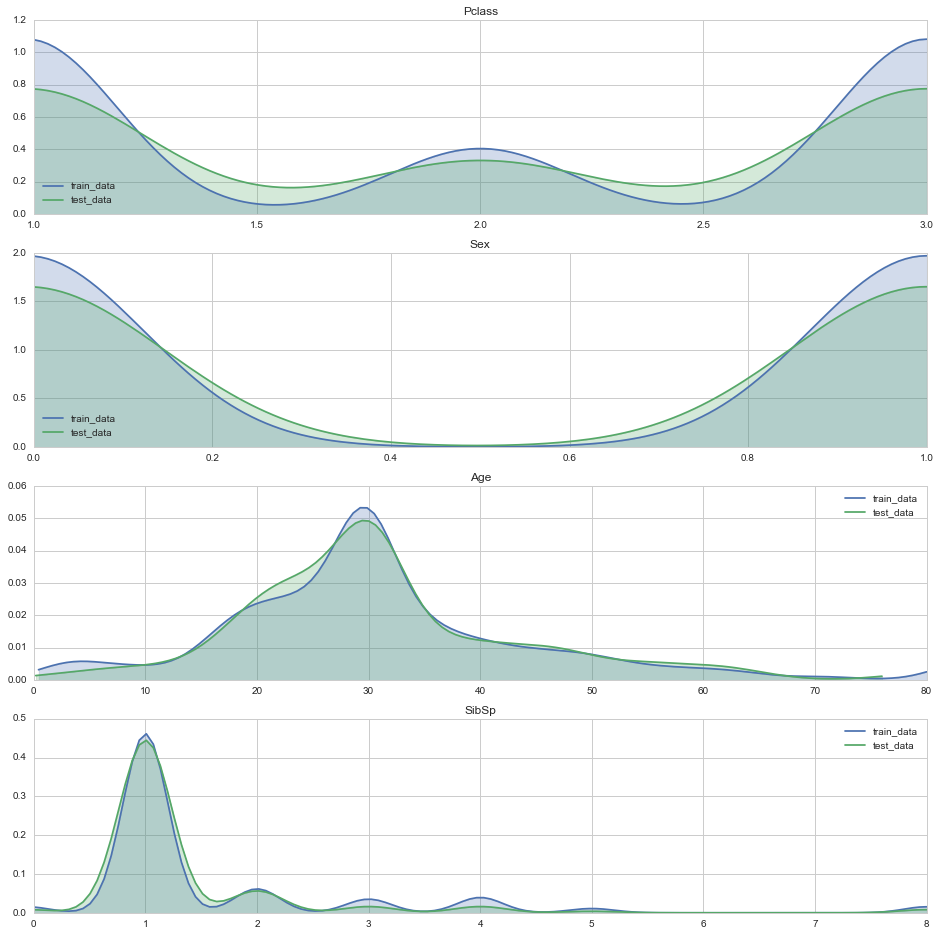

In [6]:
# Plot variable densities

f = plt.figure(figsize=(16,16))
ax0 = f.add_subplot(4,1,1)
ax1 = f.add_subplot(4,1,2)
ax2 = f.add_subplot(4,1,3)
ax3 = f.add_subplot(4,1,4)

ax0.set_title('Pclass')
sns.kdeplot(train['Pclass'], shade=True, cut=0, label='train_data',ax=ax0)
sns.kdeplot(test['Pclass'], shade=True, cut=0, label='test_data',ax=ax0)

ax1.set_title('Sex')
sns.kdeplot(train['Sex'], shade=True, cut=0, label='train_data',ax=ax1)
sns.kdeplot(test['Sex'], shade=True, cut=0, label='test_data',ax=ax1)

ax2.set_title('Age')
sns.kdeplot(train['Age'], shade=True, cut=0, label='train_data',ax=ax2)
sns.kdeplot(test['Age'], shade=True, cut=0, label='test_data',ax=ax2)

ax3.set_title('SibSp')
sns.kdeplot(train['SibSp'], shade=True, cut=0, label='train_data',ax=ax3)
sns.kdeplot(test['SibSp'], shade=True, cut=0, label='test_data',ax=ax3)

plt.show()

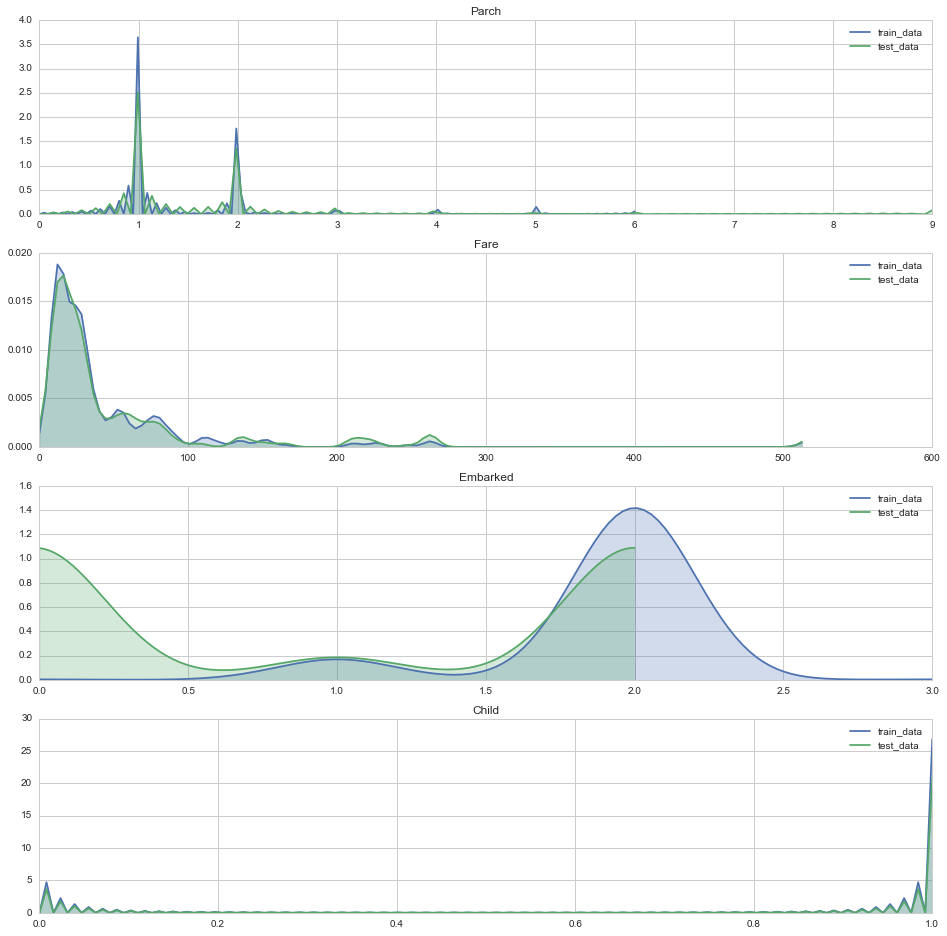

In [7]:
f = plt.figure(figsize=(16,16))
ax4 = f.add_subplot(4,1,1)
ax5 = f.add_subplot(4,1,2)
ax6 = f.add_subplot(4,1,3)
ax7 = f.add_subplot(4,1,4)

ax4.set_title('Parch')
sns.kdeplot(train['Parch'], shade=True, cut=0, label='train_data',ax=ax4)
sns.kdeplot(test['Parch'], shade=True, cut=0, label='test_data',ax=ax4)

ax5.set_title('Fare')
sns.kdeplot(train['Fare'], shade=True, cut=0, label='train_data',ax=ax5)
sns.kdeplot(test['Fare'], shade=True, cut=0, label='test_data',ax=ax5)

ax6.set_title('Embarked')
sns.kdeplot(train['Embarked'], shade=True, cut=0, label='train_data',ax=ax6)
sns.kdeplot(test['Embarked'], shade=True, cut=0, label='test_data',ax=ax6)

ax7.set_title('Child')
sns.kdeplot(train['Child'], shade=True, cut=0, label='train_data',ax=ax7)
sns.kdeplot(test['Child'], shade=True, cut=0, label='test_data',ax=ax7)

plt.show()

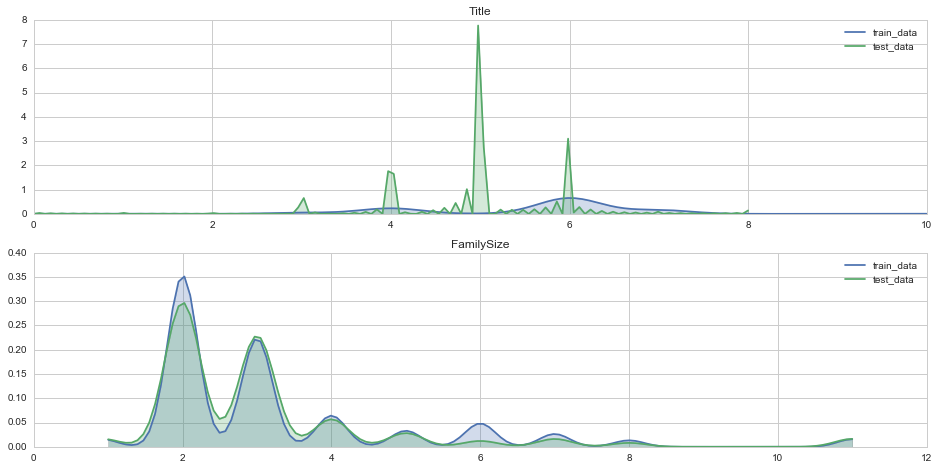

In [8]:
f = plt.figure(figsize=(16,16))
ax8 = f.add_subplot(4,1,1)
ax9 = f.add_subplot(4,1,2)

ax8.set_title('Title')
sns.kdeplot(train['Title'], shade=True, cut=0, label='train_data',ax=ax8)
sns.kdeplot(test['Title'], shade=True, cut=0, label='test_data',ax=ax8)

ax9.set_title('FamilySize')
sns.kdeplot(train['FamilySize'], shade=True, cut=0, label='train_data',ax=ax9)
sns.kdeplot(test['FamilySize'], shade=True, cut=0, label='test_data',ax=ax9)

plt.show()

In [9]:
for i in range(len(train)):
    if pd.isnull(train.Embarked[i]):
        train.Embarked[i] = 'U' # Port of Embarkation is Unknown

train.Sex = preprocessing.LabelEncoder().fit_transform(train.Sex) #Encode training data
train.Title = preprocessing.LabelEncoder().fit_transform(train.Title)
train.Embarked = preprocessing.LabelEncoder().fit_transform(train.Embarked)

test.Sex = preprocessing.LabelEncoder().fit_transform(test.Sex)
test.Title = preprocessing.LabelEncoder().fit_transform(test.Title)
test.Embarked = preprocessing.LabelEncoder().fit_transform(test.Embarked)

X = np.array(train[['Pclass','Sex','Age','SibSp','Parch','Embarked','Title','FamilySize']])
print(X[0:5])
print(X.shape)

y = np.array(train['Survived'])

print(y[0:5])
print(y.shape)

[[  3.   1.  22.   1.   0.   2.   6.   2.]
 [  1.   0.  38.   1.   0.   0.   7.   2.]
 [  3.   0.  26.   0.   0.   2.   4.   1.]
 [  1.   0.  35.   1.   0.   2.   7.   2.]
 [  3.   1.  35.   0.   0.   2.   6.   1.]]
(891, 8)
[0 1 1 1 0]
(891,)


In [10]:
n = len(X)

logit = linear_model.LogisticRegression(n_jobs = -1)
knn = neighbors.KNeighborsClassifier(n_neighbors = 30, n_jobs=-1)
rf = ensemble.RandomForestClassifier(n_jobs = -1)
gbt = ensemble.GradientBoostingClassifier()
bag = ensemble.BaggingClassifier(n_jobs = -1)
#xgb = xgb.XGBClassifier()

In [11]:
def classifier(alg, features, y, k=1):
    preprocessing.scale(features)
    knn = neighbors.KNeighborsClassifier(n_neighbors = k, n_jobs = -1)

    loocv = cross_validation.LeaveOneOut(n) # Create n training and test sets
    kfcv = cross_validation.KFold(n, n_folds = 10)
    error_rates = [] # Initialize vector of error rate for each iteration of CV
    probs = np.empty([0,2]) # Initialize nx2 matrix of prediction probabilities
    for train, test in kfcv:
        alg.fit(X[train,:], y[train]) # fit algorithm on training set
        error = 1 - alg.score(X[test,:], y[test]) # Find the error on the test set
        error_rates.append(error) # Create n-vector of error rates
        alg_train_pp = alg.predict_proba(X[test,:]) # Calculate prediction probabilities
        probs = np.append(probs, alg_train_pp, axis = 0) # Create nx2 matrix of prediction probabilities
    #gen_error_rate = sum(error_rates) / n # Gen. error is mean of n error rates in CV
    #print('Generalization Error =', gen_error_rate*100, '%')
    log_loss = metrics.log_loss(y, probs) # Calculate log-loss
    print('Accuracy = ', 1 - error)
    print('Log Loss Score =', log_loss)
    fpr, tpr, thresholds = metrics.roc_curve(y, probs[:,1])
    print('AUC = ', metrics.auc(fpr, tpr))
    print()
    return fpr, tpr

In [12]:
lfpr, ltpr = classifier(logit, X, y)
kfpr, ktpr = classifier(knn, X, y, 40)
rfpr, rtpr = classifier(rf, X, y)
gfpr, gtpr = classifier(gbt, X, y)
bfpr, btpr = classifier(bag, X, y)
#xfpr, xtpr = classifier(xgb, X, y)

Accuracy =  0.808988764045
Log Loss Score = 0.453573752622
AUC =  0.848608314959

Accuracy =  0.696629213483
Log Loss Score = 0.611416128305
AUC =  0.755736107117

Accuracy =  0.820224719101
Log Loss Score = 2.16089604607
AUC =  0.819485720981

Accuracy =  0.797752808989
Log Loss Score = 0.42909467934
AUC =  0.85451751723

Accuracy =  0.808988764045
Log Loss Score = 2.29335752959
AUC =  0.821941009171



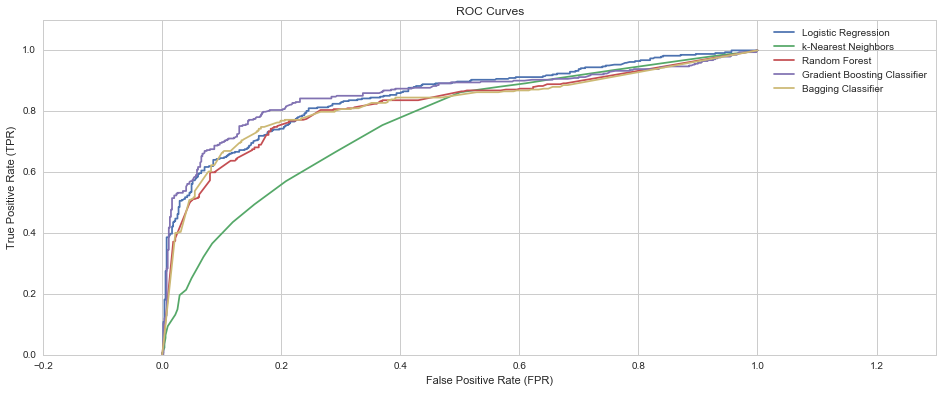

In [13]:
plt.figure(figsize=(16,6)); plt.xlim([-0.2, 1.3]); plt.ylim([0, 1.1])
plt.title('ROC Curves'); plt.xlabel('False Positive Rate (FPR)'); plt.ylabel('True Positive Rate (TPR)')
plt.plot(lfpr, ltpr, label='Logistic Regression')
plt.plot(kfpr, ktpr, label='k-Nearest Neighbors')
plt.plot(rfpr, rtpr, label='Random Forest')
plt.plot(gfpr, gtpr, label='Gradient Boosting Classifier')
plt.plot(bfpr, btpr, label='Bagging Classifier')
#plt.plot(xfpr, xtpr, label='XGBoost Classifier')
plt.legend()
plt.show()

In [14]:
X2 = np.array(test[['Pclass','Sex','Age','SibSp','Parch','Embarked','Title','FamilySize']])

survived = rf.predict(X2)
p = []
print(survived)

p = pd.DataFrame(p)
p['PassengerId'] = test.PassengerId
p['Survived'] = survived
#print(p)
p.to_csv('prediction_rf.csv', index=False)

[0 0 1 1 0 0 1 0 1 0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 1 0 0 0 1 1 1 0 0
 1 0 0 0 1 0 1 1 0 1 0 0 1 1 1 1 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 1 0 0 0
 1 1 0 1 0 1 1 0 1 0 0 0 1 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0
 1 0 1 0 0 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1
 0 1 0 0 0 0 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 1 0
 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 1 0 0 1 0 0 1 1 0 0 0 1
 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 1 0 0 1 1 0 1 1 0 0 1 1 0
 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1
 0 1 1 1 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 1 0
 1 0 1 0 1 0 0 1 0 0 1]


In [15]:
kmn = cluster.KMeans(n_clusters=2)
kmn.fit(X)

TP = 0
for i in range(len(y)):
    if kmn.predict(X)[i] == y[i]:
        TP+=1
accuracy = TP/len(y)
print(accuracy)

0.5589225589225589
